# Interpretable Machine Learning: PD5

In [1]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import io
import zipfile

from numpy.random import uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, zero_one_loss
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils.estimator_checks import is_classifier, is_regressor
from xgboost import XGBClassifier

Przekopiowałem kod do wczytywania i transformacji danych oraz trenowania modelu z PD1.

In [3]:
url = 'https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip'

def download_extract_zip(url):
    zipped = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(zipped.content)) as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                yield zipinfo.filename, thefile
                
data = download_extract_zip(url)
data = pd.read_stata(next(data)[1])

In [4]:
variables = ['ppage', 'w6_q24_length', 'w6_sex_frequency', 'w6_q23', 'w6_q27']
# Selecting variables
X = data[variables]
# Filtering observations
logical_filter = (~data.w6_q23.isna()) & (data.w6_q23 != 'Refused') & (data.w6_q27 != 'Refused')
X = X[logical_filter]
# Casting types and imputation
X.ppage = X.ppage.astype(float)
X.w6_q24_length = X.w6_q24_length.astype(float)
X.w6_sex_frequency = X.w6_sex_frequency.cat.codes.replace({-1:5, 0:5})
X.w6_q23 = X.w6_q23.astype(str)
X.w6_q27 = X.w6_q27.astype(str)
# One Hot Encoding
X = pd.get_dummies(X)
X.columns = map(lambda x: x.replace('[Partner Name]', 'PARTNER'), X.columns)

y = 1 - data.S1.cat.codes
y = y[logical_filter]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [6]:
xgb = XGBClassifier(seed=123)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

Dodałem też regresję logistyczną, która posłuży jako Champion oraz SVM, który razem z xgboostem będzie Challengerem.

In [7]:
svm = SVC(probability=True)
svm.fit(X_train,y_train)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Definicja funkcji rysującej profil PDP

In [12]:
def pdp(model, var, X, no_points, xmax=None, ylim=None, subplot=None):
    df = pd.concat([X] * no_points)
    if xmax:
        df[var] = np.repeat(np.linspace(X[var].min(), xmax, no_points), X.shape[0])
    else:
        df[var] = np.repeat(np.linspace(X[var].min(), X[var].max(), no_points), X.shape[0])
    df['preds'] = model.predict_proba(df)[:,1]
    df = df.groupby(var).agg({'preds':'mean'})
    # Plot PDP
    if subplot != None:
        plt.subplot(*subplot)
    plt.plot(df, 'grey')
    if ylim:
        plt.ylim(ylim)
    plt.xlabel(var)
    plt.ylabel('Probability of being married')
    plt.title('Partial Dependence Plot for variable ' + var)
    if not subplot:
        plt.show()

## Definicja klas do MAVI i analizy Champion-Challenger

In [9]:
class MAVI:
    """Class for plotting Model-Agnostic Variable Importances."""
    def __init__(self, model, X, y_true, loss):
        """Class constructor.
        
        Args:
            model: A model implementing the predict (for regressors) or predict_proba method.
            X: pd.DataFrame of features.
            y_true: pd.Series with true class labels.
            loss: Loss from sklearn.metrics.
        """
        assert is_classifier(model) or is_regressor(model), "Model is neither a classifier, nor a regressor"
        # Setting parameters
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
            
    def make_prediction(self, X):
        """Produce predictions depending on the type of the model.
        
        Args:
            X: pd.DataFrame of features on which to make predictions.
        """
        if is_classifier(self.model):
            return self.model.predict_proba(X)
        else:
            return self.model.predict(X)

    def switch_loss(self, var):
        """Compute loss after a permutation of one variable.
        
        Args:
            var: Variable to be permuted prior to loss computation.
        """
        df_switch = self.X.copy()
        df_switch[var] = df_switch[var].sample(frac=1).values
        preds = self.make_prediction(df_switch)
        return self.loss(self.y_true, preds)
    
    def compute_vi(self):
        """Compute variable importances for all variables."""
        base_preds = self.make_prediction(self.X)
        self.base_loss = self.loss(self.y_true, base_preds)
        self.variable_importances = {var: self.switch_loss(var) - self.base_loss
                                     for var in self.X.columns}
            
    def plot_vi(self, title, subplot=None, xlim=None):
        """Plot variable importances or add as a subplot.
        
        Args:
            title: Title to display above the plot.
            subplot: Either a tuple for plt.subplot or None, then plot will be displayed.
            xlim: Either a tuple with x limits or None, then plot will scale automatically.
        """
        if subplot:
            plt.subplot(*subplot)
        rgb = uniform(),uniform(),uniform()
        plt.barh(y=list(self.variable_importances.keys()), 
                 width=list(self.variable_importances.values()),
                 left=self.base_loss,
                 color=rgb)
        plt.axvline(self.base_loss, color=rgb, linestyle='dotted')
        plt.title(title)
        plt.xlim(xlim)
        if not subplot:
            plt.show()
        
        

class ChampionChallenger:
    """Class for Champion-Challenger model analysis."""
    def __init__(self, champion, challengers_list, X, y_true, loss):
        """Class constructor.
        
        Args:
            champion: A model to be challenged, implementing predict or predict_proba.
            chal;engers_list: A list of models implementing predict(_proba).
            X: pd.DataFrame of features.
            y_true: pd.Series with true class labels.
            loss: Loss from sklearn.metrics.
        """
        # Setting parameters
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
            
    def create_mavis(self):
        """Instantiate champion and challenger instances of the MAVI class."""
        self.champion_mavi = MAVI(self.champion, self.X, self.y_true, self.loss)
        self.champion_mavi.compute_vi()
        self.challenger_mavis = [MAVI(chall, self.X, self.y_true, self.loss) \
                                 for chall in self.challengers_list]
        for chall_mavi in self.challenger_mavis:
            chall_mavi.compute_vi()
        
    def plot_shape(self):
        """Compute plot limits and number of plots."""
        min_chall_base_loss = min(
            [cm.base_loss for cm in self.challenger_mavis]
        )
        max_chall_base_loss = max(
            [cm.base_loss for cm in self.challenger_mavis]
        )
        max_champ_vi = max(self.champion_mavi.variable_importances.values())
        max_chall_vi = max(
            [max(cm.variable_importances.values()) 
             for cm in self.challenger_mavis]
        )

        x_low = 0.9 * min(
            self.champion_mavi.base_loss, 
            min_chall_base_loss
        )
        x_high = max(max_champ_vi, max_chall_vi) + max_chall_base_loss
        self.xlim = (x_low, x_high)
        self.no_subplots = len(self.challengers_list) + 1
        
    def plot_mavis(self):
        """Create annotated MAVI plots for the Champion-Challenger analysis.
        """
        self.create_mavis()
        self.plot_shape()
        self.champion_mavi.plot_vi(
            title='Champion: ' + self.champion.__class__.__name__,
            subplot=(self.no_subplots, 1, 1),
            xlim=self.xlim
        )

        for idx, cm in enumerate(self.challenger_mavis):
            cm.plot_vi(
                title='Challenger: ' + cm.model.__class__.__name__,
                subplot=(self.no_subplots, 1, idx + 2),
                xlim=self.xlim
            )
        plt.show()

## Analiza nauczonych samodzielnie modeli

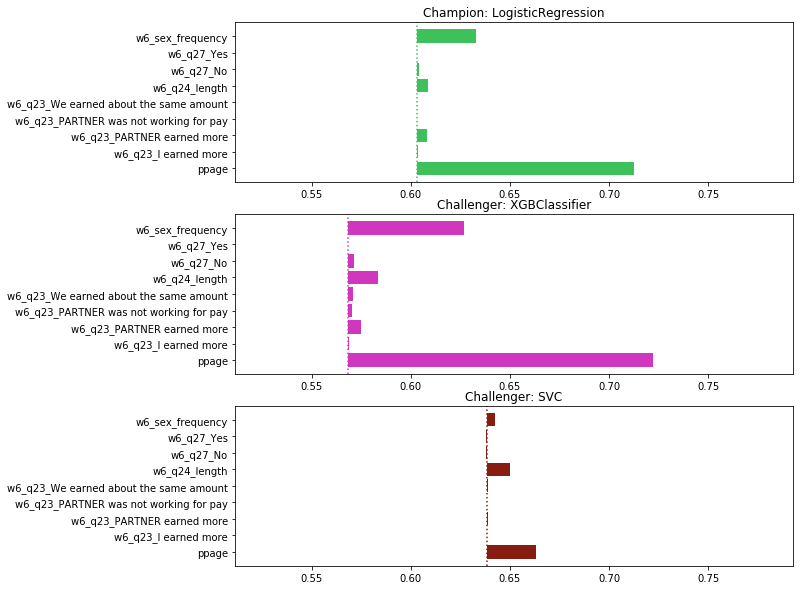

In [10]:
cc = ChampionChallenger(logreg, [xgb, svm], X_test, y_test, log_loss)
plt.figure(figsize=(10,10))
cc.plot_mavis()

Widać wyraźnie, że istotność wszystkich zmiennych kategorycznych, przekodowanych na zerojedynkowe, została oceniona bardzo podobnie. Duże znaczenie ma przede wszystkim zmienna numeryczna `ppage` oraz porządkowa `w6_sex_frequency`. Można się było tego spodziewać, ponieważ pozostałe zmienne są zerojedynkowe. Spostrzeżenie, że im człowiek starszy, tym bardziej skłonny do pozostawania w stałym związku małżeńskim, również wydaje się sensowne.

Oprócz tego widać wyraźnie, że na zbiorze testowym najlepiej radzi sobie xgboost. SVM radzi sobie gorzej niż prosty model liniowy, co znaczy, że drastycznie się przeuczył, stanie się to jeszcze bardziej widoczne na przykładzie profili PDP.

### `w6_sex_frequency`

W tym przypadku na pierwszy rzut oka widać, że xgboost uchwycił kompletnie inną zależność niż model liniowy i SVM. Może to tłumaczyć, dlaczego według tego pierwszego ta zmienna jest zdecydowanie istotniejsza niż dla dwóch pozostałych. Niskie wartości tej zmiennej oznaczają częstsze uprawianie seksu. Można stąd wnioskować, że udane życie seksualne sprzyja pozostawaniu w małżeństwie według regresji logistycznej, a według xgboosta istnieje pewien _złoty środek_. Profil PDP dla SVM jest niemal płaski, co jest zgodne z bardzo małą obliczoną istotnością `w6_sex_frequency` dla tego modelu.

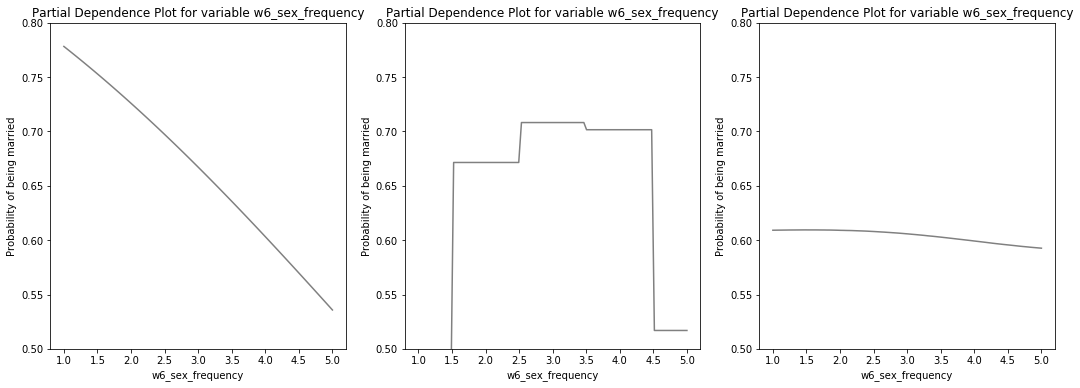

In [16]:
plt.figure(figsize=(18,6))
y_limit = (0.4, 0.8)
pdp(logreg, 'w6_sex_frequency', X_test, 100, 5, ylim=y_limit, subplot=(1,3,1))
pdp(xgb, 'w6_sex_frequency', X_test, 100, 5, ylim=y_limit, subplot=(1,3,2))
pdp(svm, 'w6_sex_frequency', X_test, 100, 5, ylim=y_limit, subplot=(1,3,3))
plt.show(block=True)

### `w6_q24_length`

Przypadek `w6_q24_length` jest ciekawy, ponieważ o ile istotność tej zmiennej może wydawać się podobna dla różnych klas modeli, to to jak wpływa na predykcję  z modelu jest zupełnie rózne. Odpowiedź dla modelu liniowego jest taka, jak byśmy się spodziewali. Dla xgboosta widać wyraźnie nieliniowe zachowanie oraz piki spowodowane pewnie nadmiernym dopasowaniem się do pewnej małej próbki skoncentrowanej na konkretnej wartości tej zmiennej. Dla SVM-a z kolei wyraźnie widać overfitting. Wykres odpowiedzi jest poszarpany, co mówi nam, że predykcja z tego modelu nie będzie zbyt wysokiej jakości na danych niewidzianych przez model.

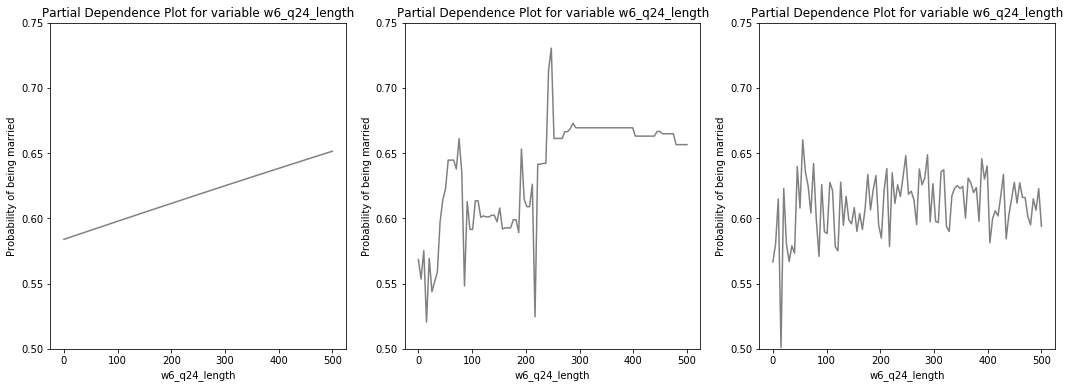

In [17]:
plt.figure(figsize=(18,6))
y_limit = (0.5, 0.75)
pdp(model=logreg, var='w6_q24_length', X=X_test, no_points=100, xmax=500, ylim=y_limit, subplot=(1,3,1))
pdp(model=xgb, var='w6_q24_length', X=X_test, no_points=100, xmax=500, ylim=y_limit, subplot=(1,3,2))
pdp(model=svm, var='w6_q24_length', X=X_test, no_points=100, xmax=500, ylim=y_limit, subplot=(1,3,3))
plt.show(block=True)

## `ppage`

W przypadku wieku wydaje się, że wszystkie modele próbowały uchwycić podobną zależność. Dla modelu liniowego profil PDP jest rosnący, co pokrywa się z grubsza z zachowaniem profili dla xgboosta i SVM. Oba modele nieliniowe uchwyciły spadek prawdopodobieństwa pozostawania w związku małżeńskim w wieku poniżej 40 lat, przy czym profil dla SVM jest dużo bardziej płaski. To może tłumaczyć niską istotność tej zmiennej.

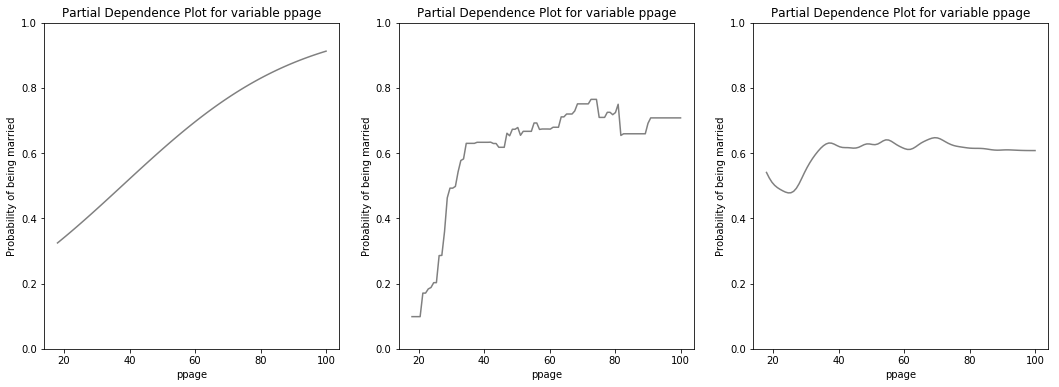

In [22]:
plt.figure(figsize=(18,6))
y_limit = (0, 1)
pdp(model=logreg, var='ppage', X=X_test, no_points=100, xmax=100, ylim=y_limit, subplot=(1,3,1))
pdp(model=xgb, var='ppage', X=X_test, no_points=100, xmax=100, ylim=y_limit, subplot=(1,3,2))
pdp(model=svm, var='ppage', X=X_test, no_points=100, xmax=100, ylim=y_limit, subplot=(1,3,3))
plt.show(block=True)